In [2]:
import pandas as pd
import sys
sys.path.append("../../scripts")
from variables import ALL_EVAL_RESULTS_PATH, SDG_MAP
import seaborn as sns
import matplotlib.pyplot as plt
from  matplotlib.ticker import PercentFormatter
from eval_predictions import iter_prediction_files, load_original_file
from glob import glob
from collections import defaultdict

In [3]:
# Gets SDG 1 to 16 predictions for project prediction files
# PROJECT_NAME = "all_undergrad_excel"
PROJECT_NAME = "2023_all_ugrad_outlines"

ref_path = f"../../data/raw/{PROJECT_NAME}.jsonl"
ref_data = pd.read_json(ref_path, lines=True)

In [4]:
def count_sdg_courses(model_name):
    counts = defaultdict(int)
    depts_w_sdg = set()
    counts["model_name"] = model_name
    paths = glob(
        f"../../data/predictions/*-{model_name}-{PROJECT_NAME}-raw__predictions.jsonl"
    )
    combined = []
    for path in paths:
        data = pd.read_json(path, lines=True)
        data = data.merge(ref_data, left_index=True, right_index=True)
        combined.append(data)

    combined = pd.concat(combined)
    combined.drop(["text_y", "index"], axis="columns", inplace=True)
    combined.rename(columns={"text_x": "text"}, inplace=True)

    aggregated_preds = []
    for i, group in combined.groupby("CRSE_ID"):
        aggregated_predictions = list(group["prediction"])
        example_row = group.iloc[0]
        example_row["prediction"] = aggregated_predictions
        aggregated_preds.append(example_row)
    
    aggregated_preds = pd.DataFrame(aggregated_preds)

    for i, row in aggregated_preds.iterrows():
        predictions = row["prediction"]
        pos_flag = 0
        for pred in predictions:
            if pred["prediction"]:
                counts[pred["category"]] += 1
                depts_w_sdg.add(row["DEPARTMENT"])
                pos_flag = 1

        if pos_flag:
            counts["has_sdg"] += 1
        
    counts["courses"] = aggregated_preds.shape[0]
    counts["total_deps"] = aggregated_preds["DEPARTMENT"].nunique()
    counts["deps_w_sdg"] = len(depts_w_sdg)
    
    return counts

def count_ref_data(ref_data):
    counts = defaultdict(int)
    depts_w_sdg = set()
    counts["model_name"] = "Manual"
    for i, row in ref_data.iterrows():
        pos_flag = 0
        for sdg in row['labels']:
            counts[sdg] += 1
            depts_w_sdg.add(row["DEPARTMENT"])
            pos_flag = 1
        
        if pos_flag:
            counts["has_sdg"] += 1
        
    counts["courses"] = ref_data.shape[0]
    counts["total_deps"] = ref_data["DEPARTMENT"].nunique()
    counts["deps_w_sdg"] = len(depts_w_sdg)
    return counts


all_sdg_counts = []
models = ["logistic_regression", "uoft_dict_approach"]
all_sdg_counts.append(count_ref_data(ref_data))
for model in models:
    all_sdg_counts.append(count_sdg_courses(model))

C:\Users\arman\AppData\Local\Temp\ipykernel_25216\291252625.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  example_row["prediction"] = aggregated_predictions
C:\Users\arman\AppData\Local\Temp\ipykernel_25216\291252625.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  example_row["prediction"] = aggregated_predictions


In [5]:
melt = pd.melt(pd.DataFrame(all_sdg_counts), id_vars=["model_name", "courses", "has_sdg", "deps_w_sdg", "total_deps"])
melt.head()

,model_name,courses,has_sdg,deps_w_sdg,total_deps,variable,value
0,Manual,2350,964,45,48,SDG 5,191.0
1,logistic_regression,2349,722,43,48,SDG 5,138.0
2,uoft_dict_approach,2349,2336,48,48,SDG 5,519.0
3,Manual,2350,964,45,48,SDG 16,267.0
4,logistic_regression,2349,722,43,48,SDG 16,212.0


In [6]:
melt["has_sdg_proportion"] = melt["value"] / melt["has_sdg"]
melt["total_proportion"] = melt["value"] / melt["courses"]
melt["deps_prop"] = melt["deps_w_sdg"] / melt["total_deps"]

In [7]:
model_mapping = dict(
    logistic_regression="Logistic regression",
    uoft_dict_approach="UofT approach"
)
melt["Model name"] = melt["model_name"].apply(lambda x: model_mapping.get(x, x))
melt = melt.sort_values("model_name")

C:\Users\arman\AppData\Local\Temp\ipykernel_25216\192976046.py:1: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.catplot(data=melt, y="has_sdg_proportion", x="variable", hue="Model name", kind='bar', height=3, aspect=4, order=SDG_MAP.keys(), palette=sns.color_palette("rocket_r"))


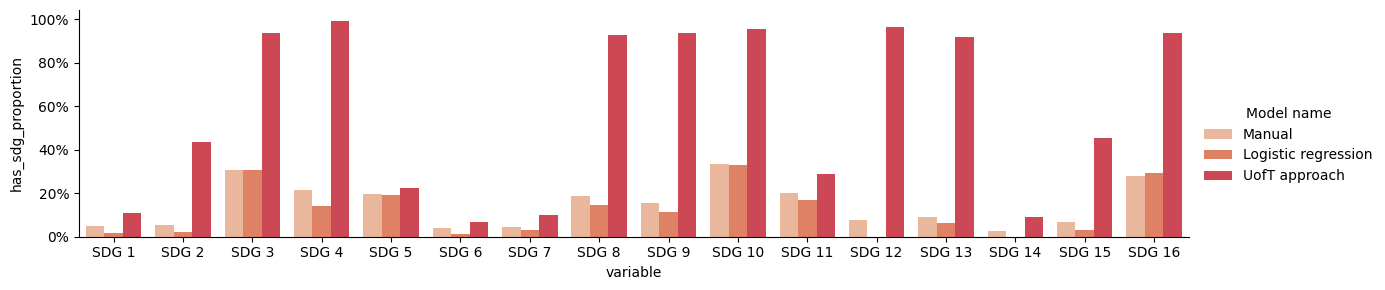

C:\Users\arman\AppData\Local\Temp\ipykernel_25216\192976046.py:7: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  g = sns.catplot(data=melt[melt["model_name"] != "uoft_dict_approach"], y="has_sdg_proportion", x="variable", hue="Model name", kind='bar', height=3, aspect=4, order=SDG_MAP.keys(), palette=sns.color_palette("rocket_r"))


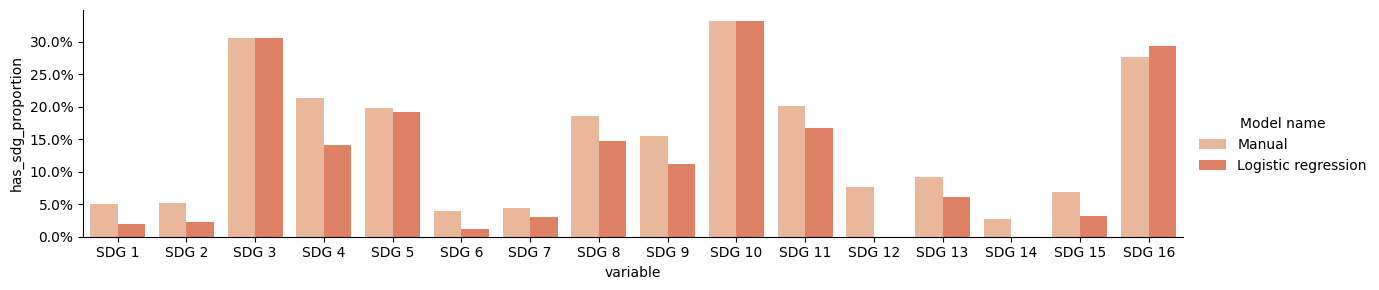

In [8]:
g = sns.catplot(data=melt, y="has_sdg_proportion", x="variable", hue="Model name", kind='bar', height=3, aspect=4, order=SDG_MAP.keys(), palette=sns.color_palette("rocket_r"))
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.savefig("../../data/presentation_figures/all_hassdg_proportion.png")
plt.show()

g = sns.catplot(data=melt[melt["model_name"] != "uoft_dict_approach"], y="has_sdg_proportion", x="variable", hue="Model name", kind='bar', height=3, aspect=4, order=SDG_MAP.keys(), palette=sns.color_palette("rocket_r"))
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.savefig("../../data/presentation_figures/some_hassdg_proportion.png")
plt.show()

C:\Users\arman\AppData\Local\Temp\ipykernel_25216\1939726645.py:1: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.catplot(data=melt, y="total_proportion", x="variable", hue="Model name", kind='bar', height=3, aspect=4, order=SDG_MAP.keys(), palette=sns.color_palette("rocket_r"))


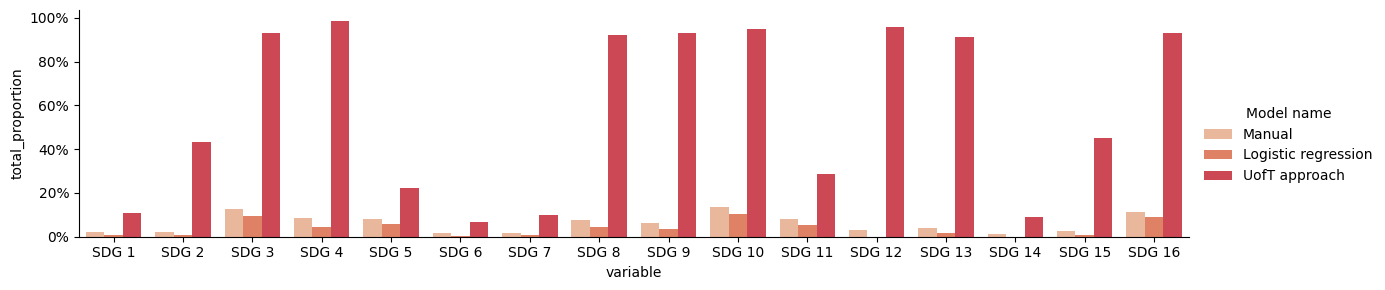

C:\Users\arman\AppData\Local\Temp\ipykernel_25216\1939726645.py:7: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  g = sns.catplot(data=melt[melt["model_name"] != "uoft_dict_approach"], y="total_proportion", x="variable", hue="Model name", kind='bar', height=3, aspect=4, order=SDG_MAP.keys(), palette=sns.color_palette("rocket_r"))


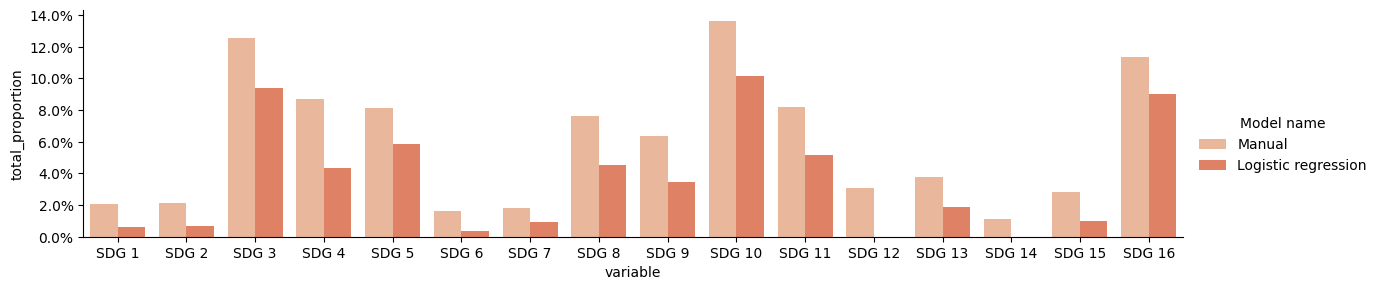

In [9]:
g = sns.catplot(data=melt, y="total_proportion", x="variable", hue="Model name", kind='bar', height=3, aspect=4, order=SDG_MAP.keys(), palette=sns.color_palette("rocket_r"))
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.savefig("../../data/presentation_figures/all_courses_proportion.png")
plt.show()

g = sns.catplot(data=melt[melt["model_name"] != "uoft_dict_approach"], y="total_proportion", x="variable", hue="Model name", kind='bar', height=3, aspect=4, order=SDG_MAP.keys(), palette=sns.color_palette("rocket_r"))
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.savefig("../../data/presentation_figures/some_courses_proportion.png")
plt.show()

# % inclusive courses

In [10]:
model_only = melt.drop_duplicates(["Model name"])
model_only["has_sdg_proportion"] = model_only["has_sdg"] / model_only["courses"]
model_only['x'] = ["0"]*model_only.shape[0]
model_only

C:\Users\arman\AppData\Local\Temp\ipykernel_25216\1223423331.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_only["has_sdg_proportion"] = model_only["has_sdg"] / model_only["courses"]
C:\Users\arman\AppData\Local\Temp\ipykernel_25216\1223423331.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_only['x'] = ["0"]*model_only.shape[0]


,model_name,courses,has_sdg,deps_w_sdg,total_deps,variable,value,has_sdg_proportion,total_proportion,deps_prop,Model name,x
0,Manual,2350,964,45,48,SDG 5,191.0,0.410213,0.081277,0.937500,Manual,0
37,logistic_regression,2349,722,43,48,SDG 1,14.0,0.307365,0.005960,0.895833,Logistic regression,0
41,uoft_dict_approach,2349,2336,48,48,SDG 6,160.0,0.994466,0.068114,1.000000,UofT approach,0


C:\Users\arman\AppData\Local\Temp\ipykernel_25216\2722733832.py:1: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.catplot(data=model_only, y="has_sdg_proportion", x="x", hue="Model name", kind='bar', height=3, aspect=1, palette=sns.color_palette("rocket_r"))


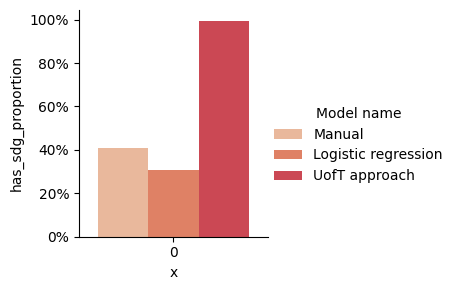

In [11]:
g = sns.catplot(data=model_only, y="has_sdg_proportion", x="x", hue="Model name", kind='bar', height=3, aspect=1, palette=sns.color_palette("rocket_r"))
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.savefig("../../data/presentation_figures/has_sdg_proportion.png")
plt.show()

C:\Users\arman\AppData\Local\Temp\ipykernel_25216\697779107.py:1: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.catplot(data=model_only, y="deps_prop", x="x", hue="Model name", kind='bar', height=3, aspect=1, palette=sns.color_palette("rocket_r"))


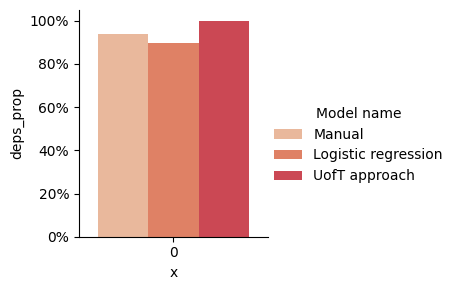

In [12]:
g = sns.catplot(data=model_only, y="deps_prop", x="x", hue="Model name", kind='bar', height=3, aspect=1, palette=sns.color_palette("rocket_r"))
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.savefig("../../data/presentation_figures/has_sdg_dep_proportion.png")
plt.show()